In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd

from src.genome import Genome
import src.draw
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = json.load(open('results/slimevolley_history_500.json'))
df = pd.DataFrame(data['history'])
df.head()

,generation,best_fitness,avg_fitness,num_species,mean_parameters,best_genome
0,0,-3.6875,-5.333496,0,39.000000,"{'nodes': {'0': {'id': 0, 'type': 0, 'level': ..."
1,1,-4.4375,-5.347656,1,39.023438,"{'nodes': {'0': {'id': 0, 'type': 0, 'level': ..."
2,2,-4.0000,-5.300293,1,39.078125,"{'nodes': {'0': {'id': 0, 'type': 0, 'level': ..."
3,3,-4.0000,-5.264160,1,39.140625,"{'nodes': {'0': {'id': 0, 'type': 0, 'level': ..."
4,4,-4.2500,-5.116211,1,39.062500,"{'nodes': {'0': {'id': 0, 'type': 0, 'level': ..."


# Plot evolution

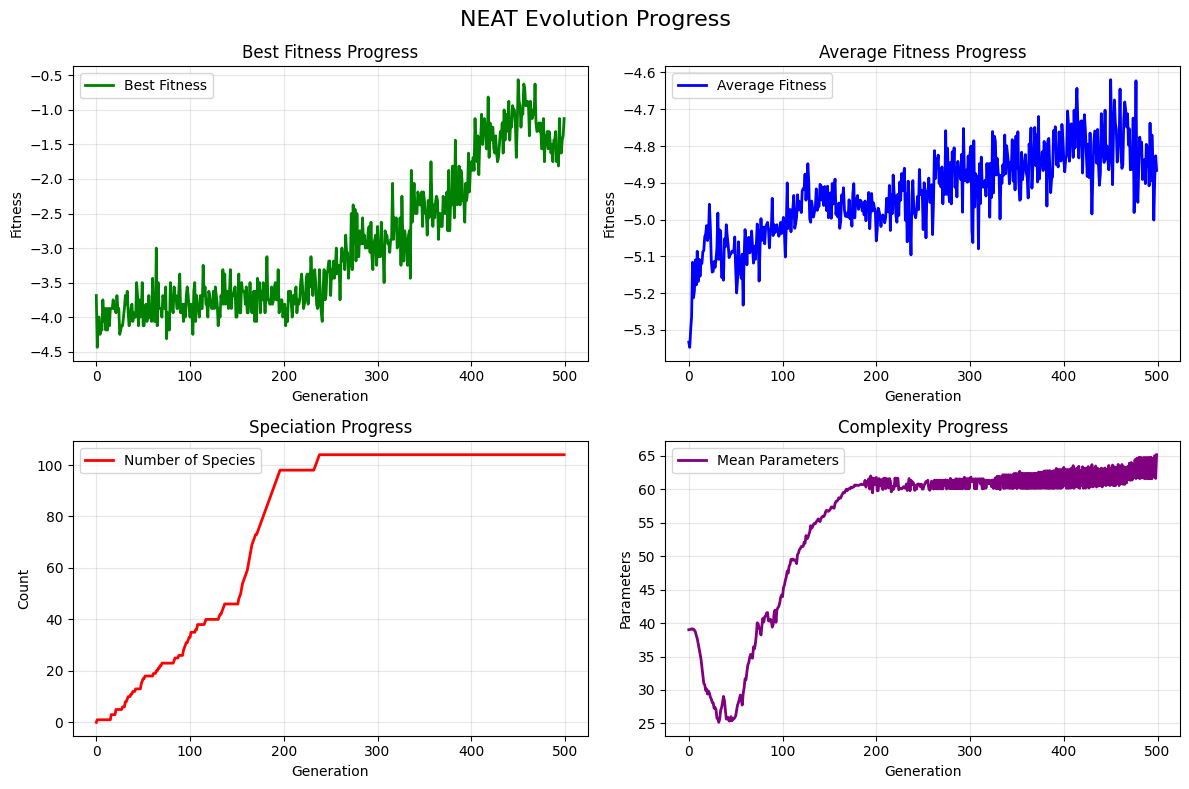

In [3]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('NEAT Evolution Progress', fontsize=16)

# Best fitness over time
ax1.plot(df['generation'], df['best_fitness'], 'g-', linewidth=2, label='Best Fitness')
ax1.set_xlabel('Generation')
ax1.set_ylabel('Fitness')
ax1.set_title('Best Fitness Progress')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Average fitness over time
ax2.plot(df['generation'], df['avg_fitness'], 'b-', linewidth=2, label='Average Fitness')
ax2.set_xlabel('Generation')
ax2.set_ylabel('Fitness')
ax2.set_title('Average Fitness Progress')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Number of species over time
ax3.plot(df['generation'], df['num_species'], 'r-', linewidth=2, label='Number of Species')
ax3.set_xlabel('Generation')
ax3.set_ylabel('Count')
ax3.set_title('Speciation Progress')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Mean parameters over time
ax4.plot(df['generation'], df['mean_parameters'], 'purple', linewidth=2, label='Mean Parameters')
ax4.set_xlabel('Generation')
ax4.set_ylabel('Parameters')
ax4.set_title('Complexity Progress')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()



Plot how the network evolves over time

In [7]:
from PIL import Image

def create_gif_from_plots(image_files, output_path, duration=200):
    # Load images
    images = [Image.open(img) for img in image_files]
    
    # Save as GIF
    images[0].save(
        output_path,
        save_all=True,
        append_images=images[1:],
        duration=duration,  # milliseconds per frame
        loop=0
    )
    
    print(f"GIF saved as {output_path}")

In [ ]:
genomes = []
generations = []
for i in range(0, len(df), 10):
    row = df.iloc[i]
    genome = Genome.from_dict(dict(row['best_genome']))
    genomes.append(genome)
    generations.append(row['generation'])

save_paths = [f'results/plots/genome_{generation}.png' for generation in generations]
src.draw.plot_evolution(genomes, save_paths=save_paths, draw_node_labels=False, generations=generations)

In [23]:
# Get all PNG files in plots directory, sorted by filename
image_files = [f'results/plots/genome_{generation}.png' for generation in generations]
create_gif_from_plots(image_files, 'results/evolution.gif', duration=300)

GIF saved as results/evolution.gif


# Visualize the Game

In [ ]:
from evojax.task.slimevolley import SlimeVolley
from src.genome import Genome
from src.topology import build_topology_and_weights, topology2policy
import jax
import jax.numpy as jnp
from jax import tree_util

def visualize_policy(policy_apply, weights, n_steps=3000, save_gif=True, out_file="slimevolley.gif"):
    env = SlimeVolley(test=True, max_steps=n_steps)
    key = jax.random.PRNGKey(1)
    key, reset_key = jax.random.split(key)
    state = env.reset(reset_key[None, :])
    imgs = []

    for t in range(n_steps):
        # state.obs already has batch dimension
        action = policy_apply(weights, state.obs)
        action = jnp.tanh(action)
        state, reward, done = env.step(state, action)
        # Extract single game state from batch for rendering
        single_state = tree_util.tree_map(lambda x: x[0], state)
        img = SlimeVolley.render(single_state)
        imgs.append(img)

        if done[0]:
            break

    # Save as GIF
    if save_gif:
        imgs[0].save(
            out_file,
            save_all=True,
            append_images=imgs[1:],
            duration=20,
            loop=0
        )
        print(f"Saved gif to {out_file}")
    else:
        # Show the last image
        imgs[-1].show()

best_fitness_idx = df['best_fitness'].idxmax()
genome_dict = df.iloc[best_fitness_idx]['best_genome'] # or 0 for the first one, -1 for the last one
genome = Genome.from_dict(genome_dict)
topology, weights = build_topology_and_weights(genome)
policy = topology2policy(topology)
visualize_policy(policy, weights, n_steps=3000, out_file=f"results/slimevolley_{best_fitness_idx}.gif")

Saved gif to results/slimevolley_450.gif
